# Imaging Hits Analysis

In [1]:
# imports
import glob
import os
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from functools import reduce
import operator
from adjustText import adjust_text

## set of features
FEAT_SETS = ["DNA", "Mito", "GFP", "AGP", "Morph"]
## platemaps
PLATEMAP_DIR = "../../1_inputs/1_snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
## img qc dir
IMG_QC_DIR = "../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/1.image_qc_outputs/{bio_rep}"
## classification analyses in SM pipeline
SM_CLASS_ANA_DIR = "../1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/classification_analyses"
## classification summary results
CLASS_RES_OUTDIR = "../1_snakemake_pipeline/2.smp_results_analyses/3.classification_results"

In [2]:
BATCH_LIST_DICT = {
    # "2024_01_23_Batch_7": "2024_02_Batch_7-8", 
    # "2024_02_06_Batch_8": "2024_02_Batch_7-8",
    # "2024_12_09_Batch_11": "2024_12_Batch_11-12", 
    # "2024_12_09_Batch_12": "2024_12_Batch_11-12",
    "2025_01_27_Batch_13": "2025_01_Batch_13-14", 
    "2025_01_28_Batch_14": "2025_01_Batch_13-14",
    # "2025_03_17_Batch_15": "2025_03_Batch_15-16", 
    # "2025_03_17_Batch_16": "2025_03_Batch_15-16"
}

BIO_REP_BATCHES_DICT = {
    # "2024_01_Batch_7-8": ("2024_01_23_Batch_7", "2024_02_06_Batch_8"),
    # "2024_12_Batch_11-12": ("2024_12_09_Batch_11", "2024_12_09_Batch_12"),
    # "2025_03_Batch_15-16": ("2025_03_17_Batch_15", "2025_03_17_Batch_16"),
    "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}

BIO_BATCH_MAP_BIO_REP = {
    # "B7A": "2024_01_Batch_7-8",
    # "B8A": "2024_01_Batch_7-8",
    # "B11A": "2024_12_Batch_11-12",
    # "B12A": "2024_12_Batch_11-12",
    "B13A": "2025_01_Batch_13-14",
    "B14A": "2025_01_Batch_13-14",
    # "B15A": "2025_03_Batch_15-16",
    # "B16A": "2025_03_Batch_15-16",
}

In [30]:
allele_meta_df = pl.DataFrame()
allele_meta_df_dict, img_well_qc_sum_dict = {}, {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        allele_meta_df_batch = pl.DataFrame()
        platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
        for platemap in platemaps:
            platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
            allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
                                        platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                        how="diagonal_relaxed").sort("plate_map_name")
            allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
            # display(allele_meta_df.head())
        allele_meta_df = pl.concat([
            allele_meta_df,
            allele_meta_df_batch
        ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
    allele_meta_df_dict[bio_rep] = allele_meta_df_batch

    # print(f"{IMG_QC_DIR.format(bio_rep=bio_rep)}/plate-well-level_img_qc_sum.csv")
    img_well_qc_sum = pl.read_csv(f"{IMG_QC_DIR.format(bio_rep=bio_rep)}/plate-well-level_img_qc_sum.csv")
    img_well_qc_sum = img_well_qc_sum.with_columns(
        pl.col("channel").replace("DAPI", "DNA").alias("channel")
    )
    img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
    img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
        pl.col("is_bg").max().alias("is_bg"),
        pl.col("s2n_ratio").mean().alias("s2n_ratio")
    ).with_columns(pl.lit("Morph").alias("channel"))
    img_well_qc_sum = pl.concat([
        img_well_qc_sum.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
        img_well_qc_sum_morph.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
    ], how="vertical_relaxed")
    img_well_qc_sum_dict[bio_rep] = img_well_qc_sum

In [22]:
imaging_summary_clinvar = pl.read_csv(
    "../../../../3_integrated_assay_analyses/1_inputs/imaging/imaging_analyses_summary_clinvar.tsv", 
    separator="\t", infer_schema_length=100000)
img_feat_hit_any = imaging_summary_clinvar.filter(
    pl.any_horizontal([pl.col(f"Altered_95th_perc_{feat}")==1 for feat in FEAT_SETS])
).unique("gene_allele")

In [7]:
img_feat_hit_dict = {}
for feat in FEAT_SETS:
    img_feat_hit = imaging_summary_clinvar.filter(pl.col(f"Altered_95th_perc_{feat}")==1).unique("gene_allele")
    img_feat_hit_dict[feat] = img_feat_hit

In [24]:
## prioritize features by thresholding or top N
def plot_top_important_feat(df, feat_cols, thres=0.01, n=10, ax=None, title="", plot=False):
    # Calculate mean and standard deviation for each column
    column_stats = df[feat_cols].agg(['mean', 'std']).T

    # Sort columns by the sum of mean and std in descending order
    sorted_columns = column_stats.sort_values(by=["mean"], ascending=False)
    if (thres):
        sorted_columns = sorted_columns[sorted_columns["mean"]>=thres]
    else:
        sorted_columns = sorted_columns.head(n)

    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(5, 4))
        ax.barh(y=sorted_columns.index, width=sorted_columns["mean"], color='skyblue') ## yerr=sorted_columns["std"], capsize=5, edgecolor='black'
        ax.set_yticks(range(len(sorted_columns.index)))
        ax.set_yticklabels(sorted_columns.index, rotation=0, fontsize=10)
        # ax.set_xlabel("Mean")
        ax.set_title(f"Features Importance Mean {title}")
        ax.axvline(x=0.01, color='r', linestyle='--')
        # plt.tight_layout()
        # plt.show()
    return sorted_columns

In [32]:
SM_CLASS_RES_DIR = "../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/classification_results/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells"
bio_rep = "2025_01_Batch_13-14"
variant_list = list(img_feat_hit_any["gene_allele"].unique()) + list(img_feat_hit_any["Gene"].unique())
key_alleles_df = img_feat_hit_any.to_pandas()
feat_import_df_feat_dict = {}
feat_allele_df_dict = {}

for feat in tqdm(["GFP","DNA","Mito","AGP","Morph"]): ## 
    feat_import_df_feat = pl.DataFrame()
    bio_rep_batches = BIO_REP_BATCHES_DICT[bio_rep]
    for batch_id in bio_rep_batches:
        feat_df = pl.scan_csv(f"{SM_CLASS_RES_DIR.format(batch_id=batch_id)}/feat_importance.csv")
        feat_df = feat_df.with_columns(
            pl.lit(batch_id).alias("Metadata_Batch"),
            pl.col("Group2").str.split('_').list.slice(-2).list.join("_").alias("Metadata_gene_allele")
        ).filter(
            (pl.col("Metadata_Feature_Type")==feat)
            &(~pl.col("Metadata_Control"))
            &((pl.col("Group1").is_in(variant_list))|(pl.col("Metadata_gene_allele").is_in(variant_list)))
        )
        meta_cols = [c for c in feat_df.collect_schema().names() if c.startswith("Metadata_") or c.startswith("Group") or c == "Batch"]
        feat_cols = [c for c in feat_df.collect_schema().names() if c not in meta_cols]
        feat_df = feat_df.with_columns([
            pl.col(c).cast(pl.Float64) for c in feat_cols
        ])
        if feat != "Morph":
            feat_cols = [
                i
                for i in feat_cols
                if (feat.lower() in i.lower())
                and ("Brightfield" not in i) ## excluding Brightfield features
            ]
        else:
            feat_cols = [
                i
                for i in feat_cols
                if ("GFP" not in i) and ("Brightfield" not in i)
            ]
        feat_df_batch = feat_df.select(meta_cols + feat_cols)
        feat_import_df_feat = pl.concat([feat_import_df_feat, feat_df_batch.collect()], how="diagonal")
    feat_import_df_feat_dict[feat] = feat_import_df_feat
    
    
    feat_df = pl.DataFrame()
    for j, allele in key_alleles_df.iterrows():
        # display(allele)
        batch_list = list(feat_import_df_feat_dict[feat].filter(
            pl.col("Metadata_gene_allele")==allele["gene_allele"]
        ).unique("Metadata_Batch")["Metadata_Batch"])
        allele_df = pl.DataFrame()
        for i, batch in enumerate(batch_list):
            batch_df = feat_import_df_feat_dict[feat].filter(
                (pl.col("Metadata_Batch")==batch)&(pl.col("Metadata_gene_allele")==allele["gene_allele"])
            )
            feat_cols = [col for col in batch_df.columns if "Metadata" not in col and "Group" not in col]
            batch_df = batch_df.filter(
                (~pl.all_horizontal([pl.col(feat_cols).is_null()]))
            )
            non_null_gfp = [col for col in feat_cols if not batch_df[col].is_null().any()]
            batch_df_col = plot_top_important_feat(batch_df.to_pandas(), 
                                                   non_null_gfp, thres=0.01,
                                                   title="B"+batch.split("_")[-1]+"_"+allele["gene_allele"])
            if not allele_df.is_empty():
                allele_df = allele_df.join(
                    pl.DataFrame(batch_df_col.reset_index()).with_columns(
                        pl.col("mean").alias(batch),
                    ).select("index", batch),
                    on="index",
                    how="full",
                    coalesce=True
                )
            else:
                allele_df = pl.DataFrame(batch_df_col.reset_index()).with_columns(
                    pl.col("mean").alias(batch)
                ).select("index", batch)
            # break
        allele_df = allele_df.with_columns(
            pl.mean_horizontal(pl.col([col for col in allele_df.columns if "Batch" in col])).alias("feat_importance"),
            pl.col("index").alias("cp_feature")
        ).select(
            pl.col(["cp_feature", "feat_importance"])
        ).rename(
            {"feat_importance": allele["gene_allele"]}
        )
        if not feat_df.is_empty():
            feat_df = feat_df.join(
                allele_df,
                left_on="cp_feature",
                right_on="cp_feature",
                how="full",
                coalesce=True
            )
        else:
            feat_df = allele_df

    feat_allele_df_dict[feat] = feat_df

100%|██████████| 5/5 [03:26<00:00, 41.28s/it]


In [39]:
feat_df_dict = {}

for feat in tqdm(["GFP","DNA","Mito","AGP","Morph"]): ## 
    gene_variant_scores_hits = imaging_summary_clinvar.filter(
        (pl.col("gene_allele").is_in(variant_list))
    )
    # display(gene_variant_scores)
    key_alleles_df = img_feat_hit_dict[feat].to_pandas()
    feat_df = pl.DataFrame()
    for j, allele in key_alleles_df.iterrows():
        # display(allele)
        batch_list = list(feat_import_df_feat_dict[feat].filter(
            pl.col("Metadata_gene_allele")==allele["gene_allele"]).unique("Metadata_Batch")["Metadata_Batch"])
        allele_df = pl.DataFrame()
        for i, batch in enumerate(batch_list):
            batch_df = feat_import_df_feat_dict[feat].filter(
                (pl.col("Metadata_Batch")==batch)&(pl.col("Metadata_gene_allele")==allele["gene_allele"])
            )
            feat_cols = [col for col in batch_df.columns if "Metadata" not in col and "Group" not in col]
            batch_df = batch_df.filter(
                (~pl.all_horizontal([pl.col(feat_cols).is_null()]))
            )
            non_null_gfp = [col for col in feat_cols if not batch_df[col].is_null().any()]
            batch_df_col = plot_top_important_feat(batch_df.to_pandas(), non_null_gfp, thres=0, 
                                                     n=5, title="B"+batch.split("_")[-1]+"_"+allele["gene_allele"])
            if not allele_df.is_empty():
                allele_df = allele_df.join(
                    pl.DataFrame(batch_df_col.reset_index()).with_columns(
                        pl.col("mean").alias(batch),
                    ).select("index", batch),
                    on="index",
                    how="full",
                    coalesce=True
                )
            else:
                allele_df = pl.DataFrame(batch_df_col.reset_index()).with_columns(
                    pl.col("mean").alias(batch)
                ).select("index", batch)
            # break
        allele_df = allele_df.with_columns(
            pl.mean_horizontal(pl.col([col for col in allele_df.columns if "Batch" in col])).alias("feat_importance"),
            pl.col("index").alias("cp_feature")
        ).select(
            pl.col(["cp_feature", "feat_importance"])
        ).rename(
            {"feat_importance": allele["gene_allele"]}
        )
        if not feat_df.is_empty():
            feat_df = feat_df.join(
                allele_df,
                left_on="cp_feature",
                right_on="cp_feature",
                how="full",
                coalesce=True
            )
        else:
            feat_df = allele_df
    
    # g = sns.clustermap(
    #     feat_df.to_pandas().set_index("cp_feature").fillna(0)>0,
    #     cmap="coolwarm",
    #     # square=True,
    #     # ax=ax,
    #     linewidths=0.2,         # <-- width of the cell borders
    #     linecolor='white',       # <-- color of the borders
    #     col_cluster=True,
    #     figsize=(8,10),
    #     cbar_pos=(-0.1, 0.45, 0.05, 0.18),
    #     cbar_kws={
    #         "ticks": [0, 1],        # ← only show 0 and 1
    #         "format": "%d",         # integer formatting
    #     }
    # )
    # g.fig.suptitle(f"{feat} Important CP Features", y=1)
    # gene_path = f"../../3_outputs/2_results_summary/{gene}"
    # if not os.path.exists(gene_path):
    #     os.makedirs(gene_path)
    # plt.savefig(f"{gene_path}/{feat}_important_cp_feats.png", dpi=400)

    feat_df_dict[feat] = feat_df

100%|██████████| 5/5 [01:36<00:00, 19.37s/it]


In [34]:
## QC-ed PQ files
ALL_PROF_QC = "../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/batch_profiles/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier.parquet"
PASS_QC_PROF_PQ = "../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/batch_profiles/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"

In [40]:
# Paths
ref_var_cell_qc_prof_df = pl.DataFrame()
target_gene_alleles = []
meta_cols = [
    "Metadata_CellID",
    "Metadata_gene_allele",
    "Metadata_Well",
    "Metadata_Plate",
    "Metadata_node_type"
]

# Get meta features
bio_rep_batches = BIO_REP_BATCHES_DICT[bio_rep]
for batch_id in bio_rep_batches:
    batch_alleles = (
        pl.scan_parquet(
            PASS_QC_PROF_PQ.format(batch_id=batch_id)
        )
        .filter(pl.col("Metadata_gene_allele").is_in(variant_list))
        .with_columns(
            pl.concat_str(
                [
                    "Metadata_Plate",
                    "Metadata_Well",
                    "Metadata_ImageNumber",
                    "Metadata_ObjectNumber",
                ],
                separator="_",
            ).alias("Metadata_CellID")
        )
    ).collect()
    # feat_cols = [col for col in batch_alleles.columns if ("AGP".lower() in col.lower() or "DNA".lower() in col.lower() or "Mito".lower() in col.lower()) and ("GFP".lower() not in col.lower())]
    batch_alleles = batch_alleles.join(
        img_well_qc_sum_dict[bio_rep].filter(pl.col("channel")==feat).select(pl.col("plate", "well", "is_bg")),
        left_on=["Metadata_Plate", "Metadata_Well"],
        right_on=["plate", "well"]
    ).filter(
        ~pl.col("is_bg")
    ).select(pl.col(meta_cols))
    ref_var_cell_qc_prof_df = pl.concat([ref_var_cell_qc_prof_df, batch_alleles], how="diagonal_relaxed")

In [42]:
def remove_corr_feats(df, feat_cols=None, corr_thres=.9):
    if feat_cols is None:
        # 2. Identify numeric columns
        all_num_feats = [
            name
            for name, dtype in df.schema.items()
            if dtype in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64)
        ]
    else:
        all_num_feats = feat_cols
        
    # 3. Bring that slice into pandas
    pdf = df.select(all_num_feats).to_pandas()
    # 4. Compute absolute correlation matrix
    corr = pdf.corr().abs()
    # 5. Mask out the lower triangle (we only need one side)
    upper = corr.where(
        np.triu(np.ones(corr.shape), k=1).astype(bool)
    )
    # 6. Pick columns to drop: any column with correlation > threshold to *any* other
    to_drop = [col for col in upper.columns if any(upper[col] > corr_thres)]
    # 7. Drop them in your original Polars DF
    df_drop_corr_cols = df.drop(to_drop)
    # colocal_col_cat = set(["_".join(col.split('_')[1:3]) for col in colocal_cols])
    # print(colocal_col_cat)
    # colocal_col_dict = defaultdict(list)
    # for col in colocal_cols:
    #     colocal_col_dict["_".join(col.split('_')[1:3])].append(col)
    # colocal_col_dict
    return df_drop_corr_cols


def inverse_normal_transform(data, feat_cols=None):
    """
    Apply inverse normal transformation (rank-based normalization) to data.
    """
    from scipy.stats import norm
    from scipy.stats import rankdata
    
    def transform_column_polars(col_name, df):
        """Transform a polars column"""
        return (
            pl.when(pl.col(col_name).is_not_null())
            .then(
                pl.col(col_name)
                .rank(method="average")
                .sub(0.5)
                .truediv(pl.col(col_name).drop_nulls().len())
                .map_elements(lambda x: norm.ppf(x), return_dtype=pl.Float64)
            )
            .otherwise(pl.col(col_name))
            .alias(col_name)
        )

    if feat_cols is None:
        numeric_cols = [
            col 
            for col in data.columns 
            if data[col].dtype in [pl.Float32, pl.Float64, pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64]
        ]
    else:
        numeric_cols = feat_cols
        
    # Polars DataFrame
    
    # Apply transformation to numeric columns only
    transformations = [transform_column_polars(col, data) for col in numeric_cols]
    non_numeric_cols = [col for col in data.columns if col not in numeric_cols]
    
    if transformations:
        if non_numeric_cols:
            # Keep non-numeric columns as they are
            return data.with_columns(transformations).select(data.columns)
        else:
            return data.with_columns(transformations)
    else:
        return data  # No numeric columns to transform

<Figure size 640x480 with 0 Axes>

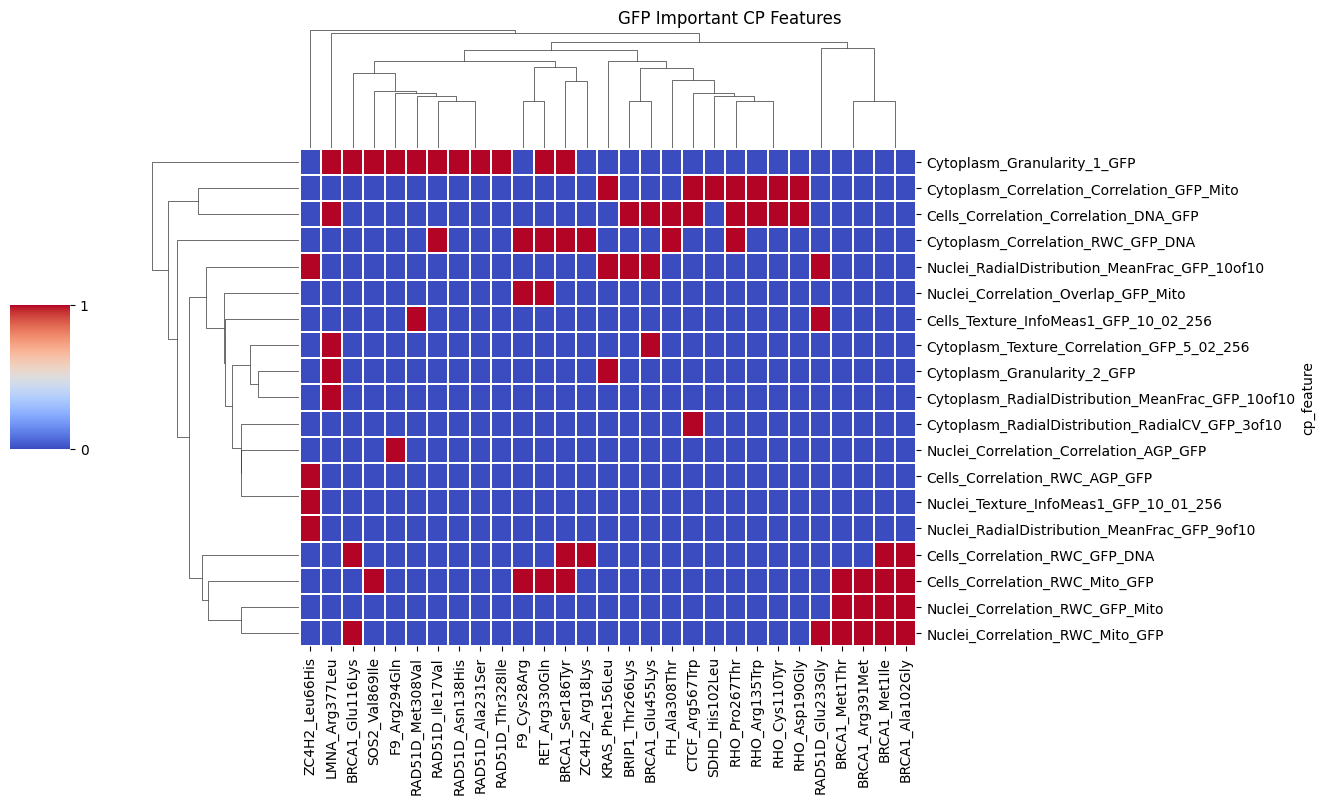

<Figure size 640x480 with 0 Axes>

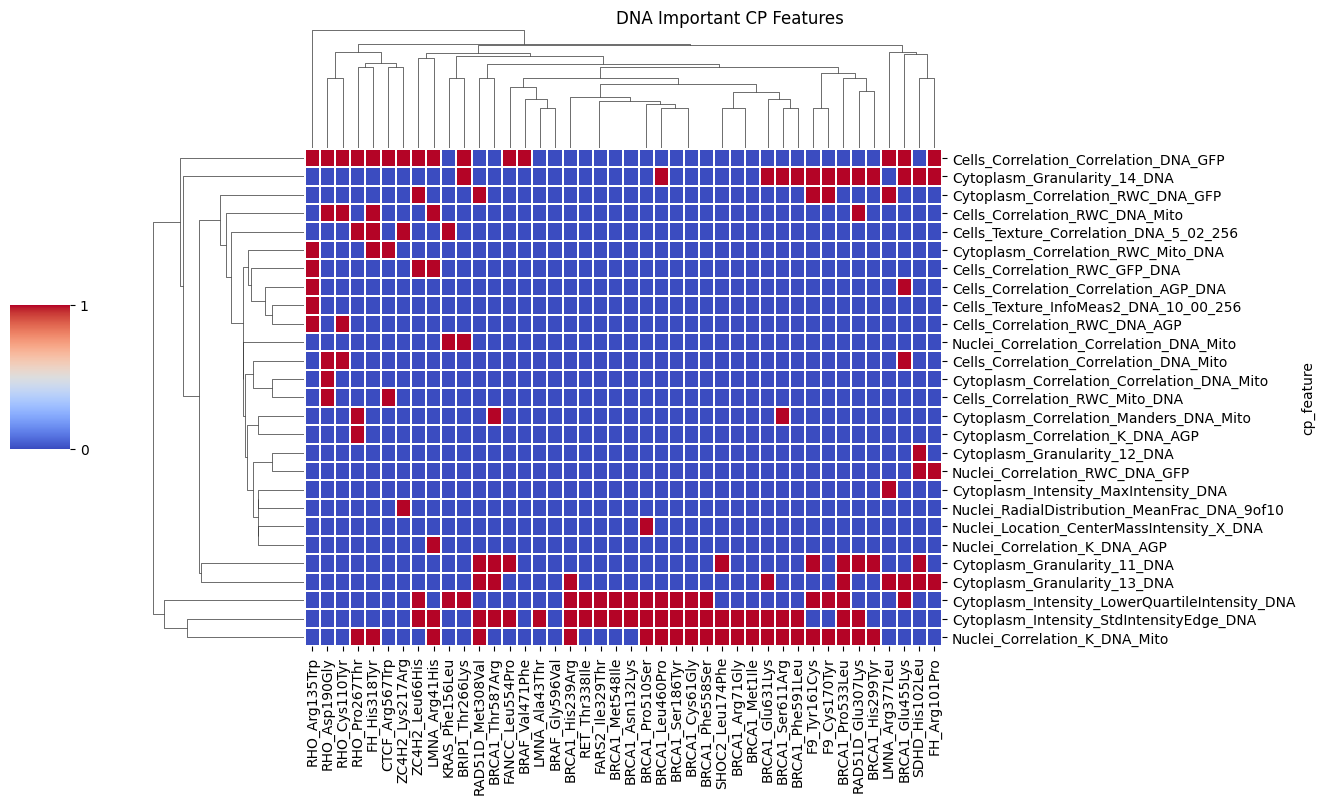

<Figure size 640x480 with 0 Axes>

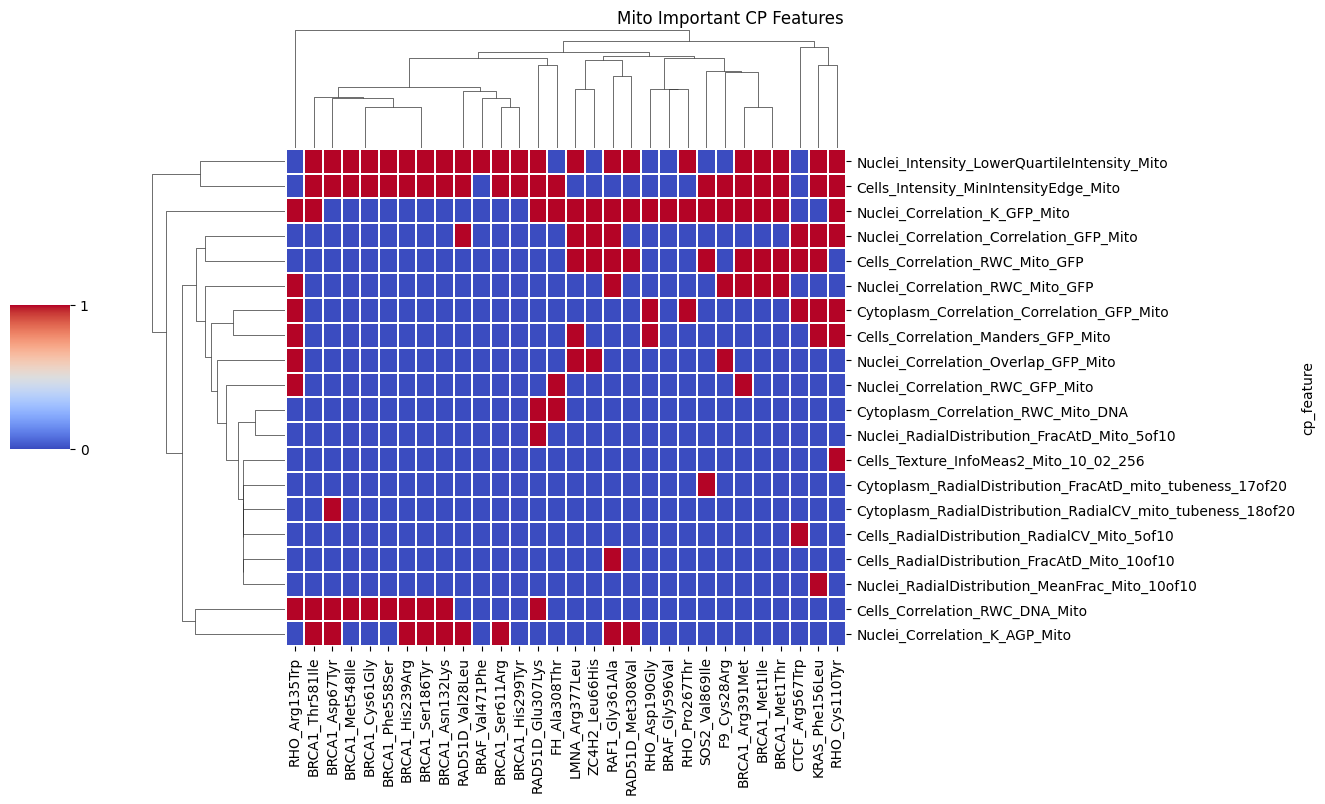

<Figure size 640x480 with 0 Axes>

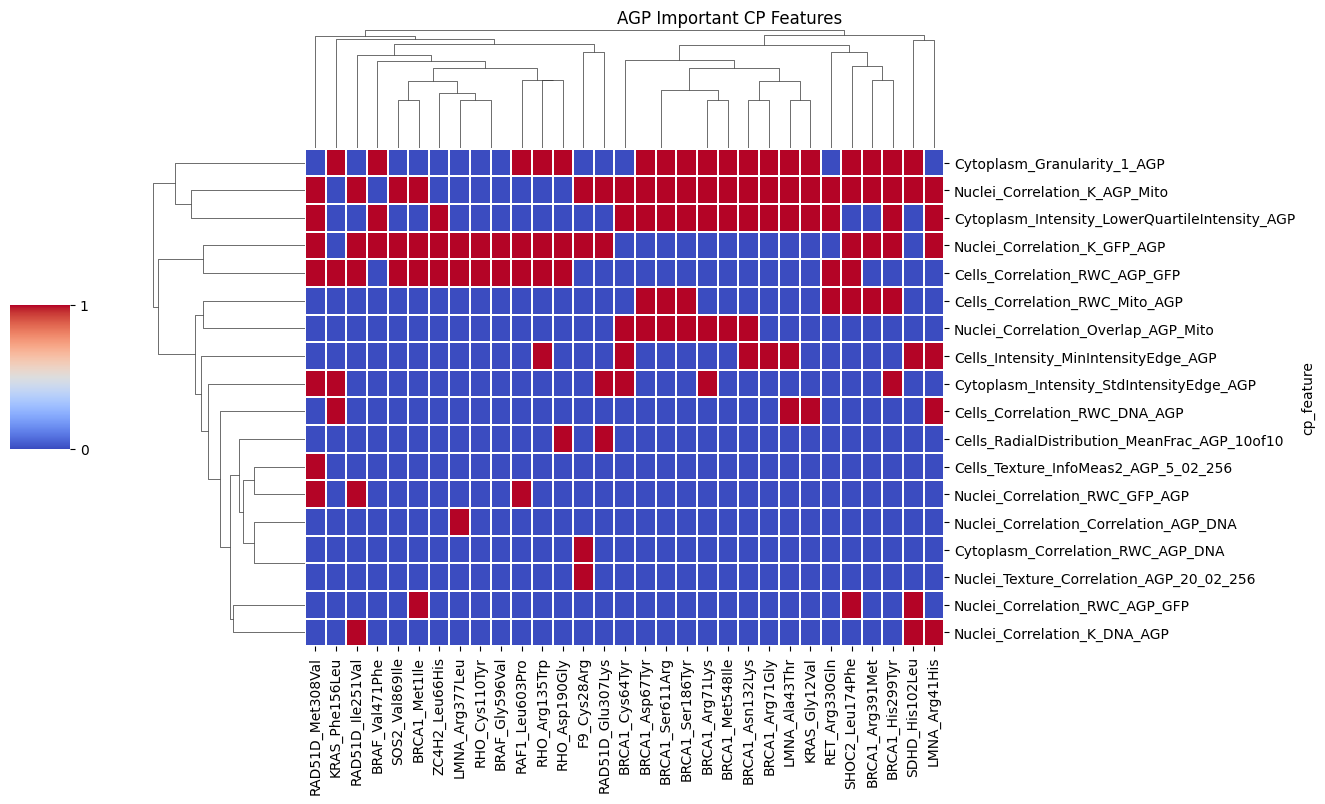

<Figure size 640x480 with 0 Axes>

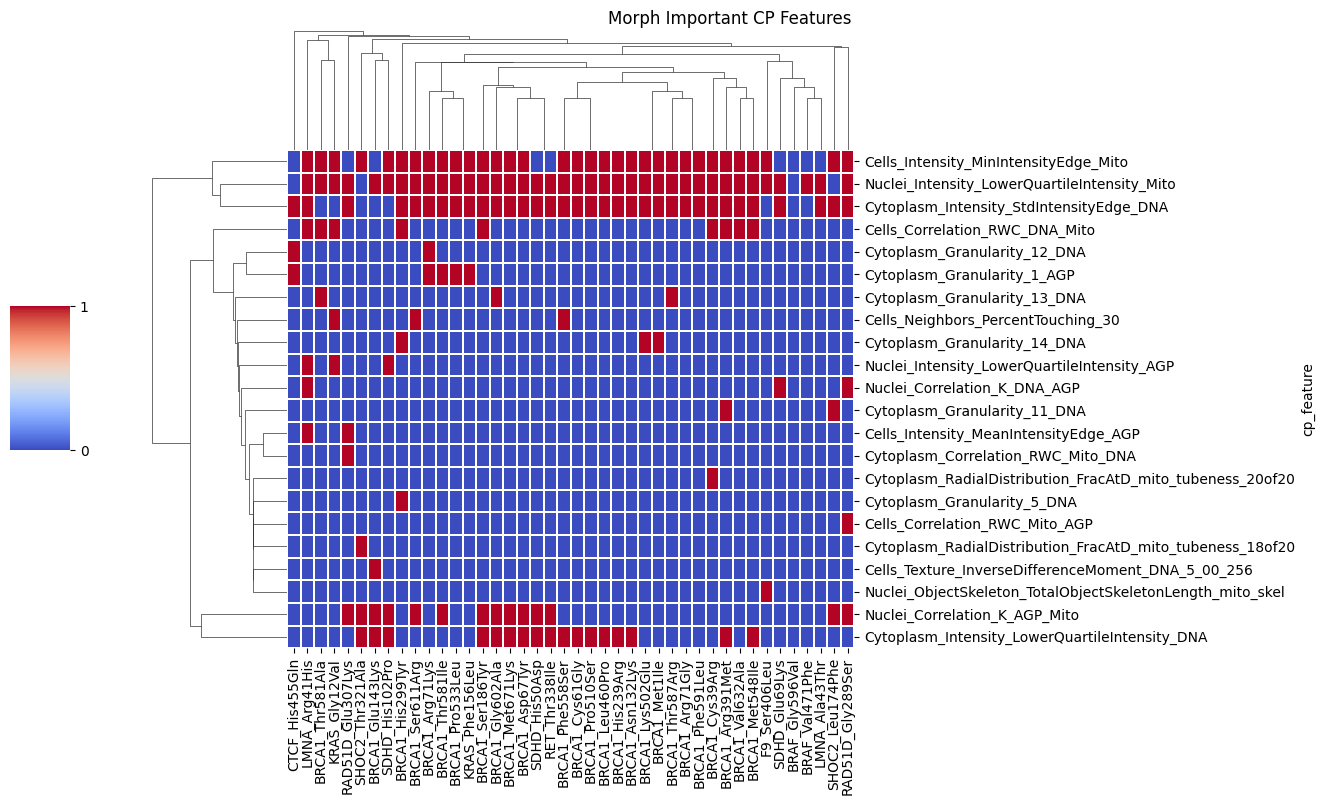

In [52]:
for feat, feat_allele_df in feat_df_dict.items():
    ref_var_cell_all_prof_list = []
    for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
        for batch_id in bio_rep_batches:
            batch_alleles = (
                pl.scan_parquet(
                    ALL_PROF_QC.format(batch_id=batch_id)
                )
                .filter(pl.col("Metadata_gene_allele").is_in(variant_list))
                .with_columns(
                    pl.concat_str(
                        [
                            "Metadata_Plate",
                            "Metadata_Well",
                            "Metadata_ImageNumber",
                            "Metadata_ObjectNumber",
                        ],
                        separator="_",
                    ).alias("Metadata_CellID")
                )
            )
            ref_var_cell_all_prof_list.append(batch_alleles)
    
    all_feat_cols = list(feat_allele_df["cp_feature"])
    select_cols = list(all_feat_cols) + ["Metadata_CellID"]
    # set(select_cols).intersection(batch_alleles.collect_schema().names())
    
    ref_var_cell_all_prof_df = pl.concat([
        batch_alleles.select(set(select_cols).intersection(batch_alleles.collect_schema().names())).collect() for batch_alleles in ref_var_cell_all_prof_list
    ], how="diagonal")
    # This method of joining ensures that only cells past filters are included in the abundance analysis
    ref_var_cell_all_prof_df = ref_var_cell_qc_prof_df.join(ref_var_cell_all_prof_df, 
                                                            on="Metadata_CellID", how="left", coalesce=True)

    ref_var_cell_all_prof_df = ref_var_cell_all_prof_df.with_columns(
        pl.col("Metadata_Plate")
          # capture a “B” followed by any non-underscore chars up to the first “A”
          .str.extract(r"(B[^_]*?A)", 1)
          .alias("Metadata_Batch")
    ).with_columns(
        pl.col("Metadata_Batch").replace(BIO_BATCH_MAP_BIO_REP).alias("Metadata_Bio_Batch")
    )
    
    ref_var_allele_batch_all_prof_df = ref_var_cell_all_prof_df.group_by(
        "Metadata_Plate", "Metadata_Well", "Metadata_gene_allele", "Metadata_Bio_Batch"
    ).agg(
        pl.col(col).median().alias(col)
        for col in all_feat_cols
        if not col.startswith("Metadata_")
    ).group_by(
        "Metadata_gene_allele", "Metadata_Bio_Batch"
    ).agg(
        pl.col(col).median().alias(col)
        for col in all_feat_cols
        if not col.startswith("Metadata_")
    ).unique(subset=["Metadata_gene_allele","Metadata_Bio_Batch"])
    
    non_null_cols_batch = [col for col in ref_var_allele_batch_all_prof_df.columns if not ref_var_allele_batch_all_prof_df[col].is_null().any() and "Metadata" not in col]
    var_allele_meta_cols = [col for col in ref_var_allele_batch_all_prof_df.columns if "Metadata" in col]
    ref_var_allele_batch_all_prof_df = ref_var_allele_batch_all_prof_df.select(
        var_allele_meta_cols+non_null_cols_batch
    )

    ## normalize the features
    ref_var_allele_batch_proc_prof_df = inverse_normal_transform(ref_var_allele_batch_all_prof_df)
    ## remove corr features
    ref_var_allele_batch_proc_prof_df = remove_corr_feats(ref_var_allele_batch_proc_prof_df, corr_thres=0.8)

    g = sns.clustermap(
        feat_allele_df.filter(
            pl.col("cp_feature").is_in([c for c in ref_var_allele_batch_proc_prof_df.columns if "Metadata" not in c])
        ).to_pandas().set_index("cp_feature").fillna(0)>0,
        cmap="coolwarm",
        # square=True,
        # ax=ax,
        linewidths=0.2,         # <-- width of the cell borders
        linecolor='white',       # <-- color of the borders
        col_cluster=True,
        figsize=(12,8),
        cbar_pos=(-0.1, 0.45, 0.05, 0.18),
        cbar_kws={
            "ticks": [0, 1],        # ← only show 0 and 1
            "format": "%d",         # integer formatting
        }
    )
    g.fig.suptitle(f"{feat} Important CP Features", y=1)
    gene_path = f"../../3_outputs/2_results_summary"
    if not os.path.exists(gene_path):
        os.makedirs(gene_path)
    plt.show()
    plt.savefig(f"{gene_path}/{feat}_important_cp_feats.png", dpi=400)